# Introduction and Motivation

In the era of digital media, music streaming platforms have transformed how we discover and enjoy music. Services like Spotify have millions of tracks available at our fingertips, making music recommendation systems essential for enhancing user experience. Recognizing the significance of these systems, our team chose to explore the “Spotify Tracks, Genre, Audio Features” dataset from Kaggle (https://www.kaggle.com/datasets/pepepython/spotify-huge-database-daily-charts-over-3-years/data) using PySpark to analyze trends and build a music recommendation model.

Our motivation for selecting this dataset is rooted in a desire to engage with a more intriguing and relatable subject matter than the typical technical datasets we’ve encountered in previous classes. Music is a universal language, and understanding how recommendation systems work within this context is both exciting and relevant. Music recommendation models are increasingly important as the amount of data generated online continues to grow, impacting how users interact with streaming services.

The primary objectives of our project are twofold:
1. Data Analysis: We aim to understand trends within the music data by examining how different genres relate to specific audio feature metrics. For example, we want to investigate whether certain genres consistently exhibit higher danceability scores or how energy levels vary across genres.
2. Model Building: Utilizing machine learning techniques, we plan to develop a music recommendation model. This model will leverage the insights gained from our data analysis to suggest tracks that align with user preferences based on audio features.

Our project focuses on mainstream music, as the dataset predominantly features popular tracks. While we have considered algorithms like K-Nearest Neighbors for recommendation, we will determine the most suitable machine learning methods as we progress, ensuring they align with our dataset characteristics and project goals.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection

In [111]:
from pyspark.sql import SparkSession


if SparkSession._instantiatedSession is not None:
    print("An existing SparkSession is detected.")
    SparkSession._instantiatedSession.stop()


# Initialize a Spark session
# Start a new Spark session
spark = SparkSession.builder \
    .appName("MusicDataAnalysisProject") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()


spark.sparkContext.setLogLevel("ERROR")

# Path to your CSV file
csv_path = "drive/MyDrive/612_files/Final database.csv"

music_df = spark.read.option("header", "true").csv(csv_path, inferSchema=True)
music_df = music_df.withColumnRenamed("Country", "Country0")

# Show the first few rows to verify
music_df.show()


An existing SparkSession is detected.
+-----------+--------------------+------------------+---------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+---+--------+----+-----------+-------------------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-------------------+------------+-------------------+-------------------+------------------+-------------+-------------------+------------------+-------------------+-----------+---

# Data Inspection and Validation

Numerical columns are String in the schema, so we'll convert them to numeric types later on (Data Transformation).

In [112]:
# Print the schema of the DataFrame
music_df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acoustics: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveliness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: 

Check for null and duplicates in the dataset. Also, check the distribution of popularity scores because later we will categoprize the data by low, medium, and high popularity levels.

In [113]:
from pyspark.sql.functions import col, sum, count, when
# Count null values in each column
null_counts = music_df.select([count(when(col(c).isNull(), c)).alias(c) for c in music_df.columns])
null_counts.show()

# Check for duplicates
duplicate_count = music_df.count() - music_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Check popularity range for validity (e.g., ensure no extreme outliers)
music_df.select("Popularity").describe().show()


+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+-----+--------------+-------------+--

# Data Transformation

In [114]:
from pyspark.sql.functions import col

# List of columns to cast to integer or double as appropriate
int_columns = ["Track_number", "Tracks_in_album", "time_signature", "Argentina", "Australia", "Austria",
               "Belgium", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Denmark", "Ecuador",
               "Finland", "France", "Germany", "Global", "Indonesia", "Ireland", "Italy", "Malaysia",
               "Mexico", "Netherlands", "New Zealand", "Norway", "Peru", "Philippines", "Poland",
               "Portugal", "Singapore", "Spain", "Sweden", "Switzerland", "Taiwan", "Turkey", "UK", "USA"]

double_columns = ["Popularity", "Artist_followers", "danceability", "energy", "key", "loudness",
                  "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence",
                  "tempo", "duration_ms", "Days_since_release", "syuzhet_norm", "bing_norm", "afinn_norm",
                  "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation", "disgust", "fear",
                  "joy", "sadness", "surprise", "trust", "negative", "positive", "n_words", "anger_norm",
                  "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm", "sadness_norm", "surprise_norm",
                  "trust_norm", "negative_norm", "positive_norm", "anger_norm2", "anticipation_norm2",
                  "disgust_norm2", "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2",
                  "negative_norm2", "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes",
                  "Negative_Bayes", "Neutral_Bayes", "Positive_Bayes", "Desire", "Explore", "Fun",
                  "Hope", "Love", "Nostalgia", "Thug", "bing_norm_negative"]

transformed_df = music_df

# Cast columns to integer
for column in int_columns:
    transformed_df = transformed_df.withColumn(column, col(column).cast("int"))

# Cast columns to double
for column in double_columns:
    transformed_df = transformed_df.withColumn(column, col(column).cast("double"))

# Fill Null values (REPLACE WITH BETTER FILLING METHOD HERE)
transformed_df = transformed_df.fillna(0)

# Verify the updated schema
transformed_df.printSchema()


root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = false)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: double (nullable = false)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: integer (nullable = true)
 |-- Tracks_in_album: integer (nullable = true)
 |-- danceability: double (nullable = false)
 |-- energy: double (nullable = false)
 |-- key: double (nullable = false)
 |-- loudness: double (nullable = false)
 |-- mode: double (nullable = false)
 |-- speechiness: double (nullable = false)
 |-- acoustics: double (nullable = false)
 |-- instrumentalness: double (nullable = false)
 |-- liveliness: double (nullable = false)
 |-- valence: double (nullable = false)
 |-- tempo: double (nullable = false)
 |-

In [115]:
# Define popularity categories for later
transformed_df = transformed_df.withColumn(
    "PopularityCategory",
    when(transformed_df.Popularity < 5000, "Low")
    .when((transformed_df.Popularity >= 5000) & (transformed_df.Popularity < 18000), "Medium")
    .otherwise("High")
)

In [116]:
# Further refine by North America
filtered_df = transformed_df.filter((music_df.Country0 == "USA") | (music_df.Country0 == "Canada") | (music_df.Country0 == "Mexico"))

print(f"Number of rows: {filtered_df.count()}")


Number of rows: 15113


# Exploratory Data Analysis

In [159]:
# Print transformed dataset shape
(filtered_df.count(), len(filtered_df.columns))

(15113, 152)

In [160]:
# Number of unique artists and songs in transformed dataset
print("Unique artists:", filtered_df.select(["Artist"]).distinct().count())
print("Unique songs:", filtered_df.select(["Title","Artist"]).distinct().count())

Unique artists: 4089
Unique songs: 8166


In [161]:
# Define relevant numerical features to explore
numerical_features = [
   "Popularity", "Artist_followers", "danceability", "energy", "key", "loudness",
    "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence",
    "tempo", "duration_ms", "time_signature", "Days_since_release", "Released_after_2017",
    "Explicit_false", "Explicit_true", "syuzhet_norm", "bing_norm", "afinn_norm",
    "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation",
    "disgust", "fear", "joy", "sadness", "surprise", "trust", "negative", "positive",
    "n_words", "anger_norm", "anticipation_norm", "disgust_norm", "fear_norm",
    "joy_norm", "sadness_norm", "surprise_norm", "trust_norm", "negative_norm",
    "positive_norm", "anger_norm2", "anticipation_norm2", "disgust_norm2", "fear_norm2",
    "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2", "negative_norm2",
    "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes", "Negative_Bayes",
    "Neutral_Bayes", "Positive_Bayes", "Popu_max", "Top10_dummy", "Top50_dummy"
]

# Filter the DataFrame for these columns
numerical_df = filtered_df.select([col for col in numerical_features if col in transformed_df.columns])

# Perform .describe()
numerical_df.describe().show()

+-------+------------------+--------------------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+----

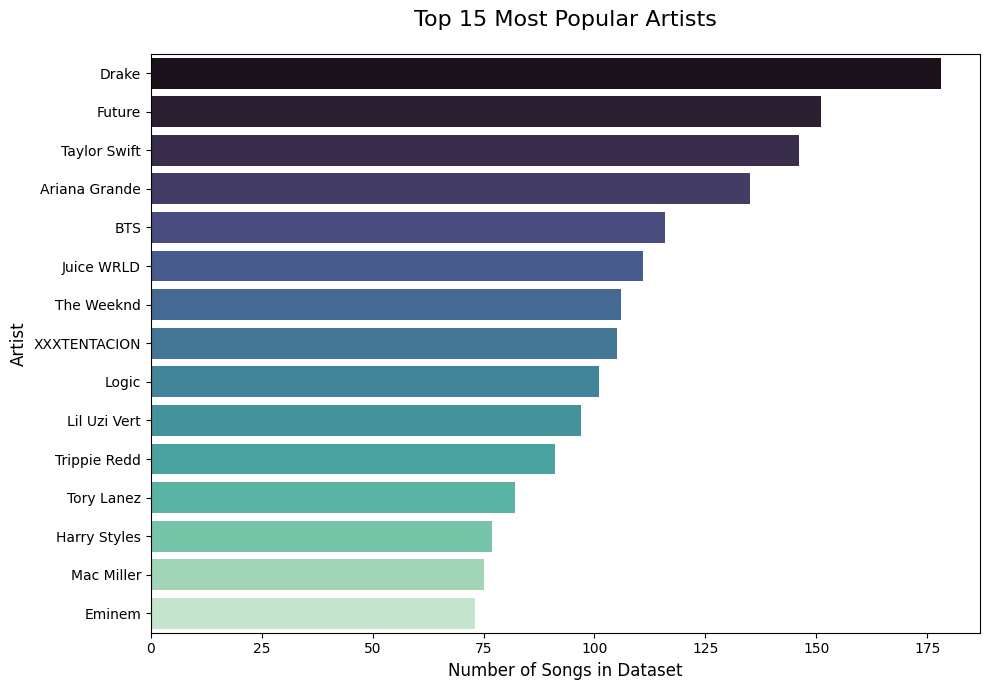

In [162]:
# Plot top 15 most popular Artists by song count
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each artist
artist_counts = (
    filtered_df.groupBy("Artist")
    .count()
    .orderBy(col("count").desc())  # Sort in descending order
    .limit(15)  # Select the top 15 artists
    .toPandas()  # Convert to Pandas for visualization
)

# Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=artist_counts, x="count", y="Artist", hue="Artist", legend = False, palette='mako')

# Customize the plot
plt.title("Top 15 Most Popular Artists", fontsize=16, pad=20)
plt.xlabel("Number of Songs in Dataset", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

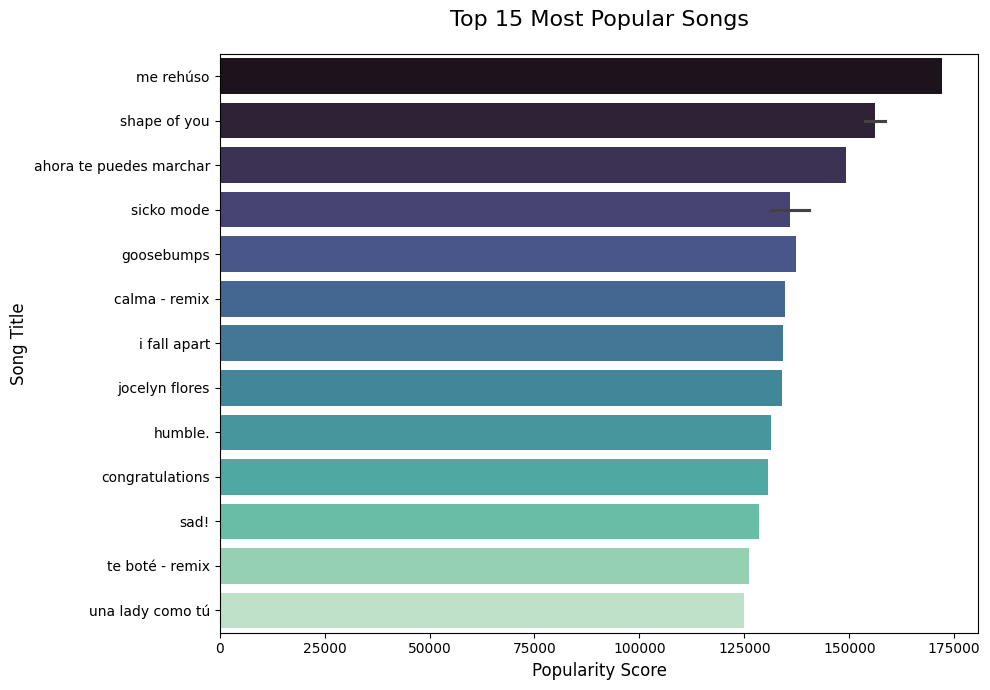

In [164]:
# Plot top 15 most popular songs by Popularity
popular_songs = (
    filtered_df.select("Title", "Popularity")
    .orderBy(col("Popularity").desc())
    .limit(15)
    .toPandas()
)

# Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=popular_songs, x="Popularity", y="Title", hue="Title", legend = False, palette='mako')

# Customize the plot
plt.title("Top 15 Most Popular Songs", fontsize=16, pad=20)
plt.xlabel("Popularity Score", fontsize=12)
plt.ylabel("Song Title", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

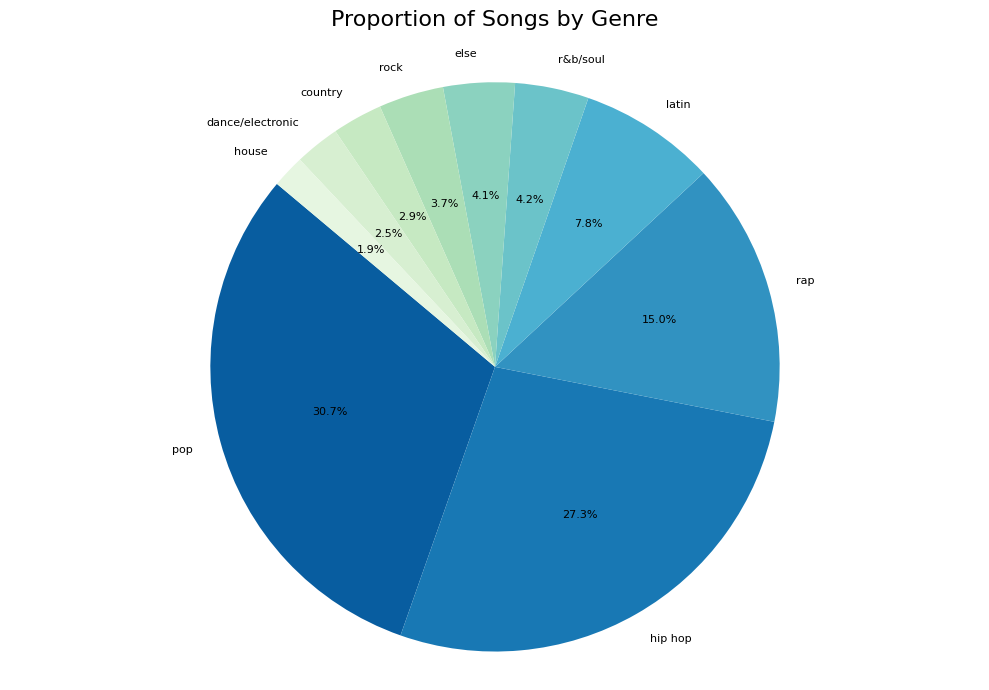

In [165]:
# Plot top 10 Most Frequent Genres
#  Group data by Genre and count the number of songs per genre
genre_counts = (
    filtered_df.groupBy("Genre_new")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

# Generate colors
colors = sns.color_palette("GnBu_r", len(genre_counts)).as_hex()

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(
    genre_counts["count"],
    labels=genre_counts["Genre_new"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
     textprops={'fontsize': 8}
)

# Customize the plot
plt.title("Proportion of Songs by Genre", pad=20, fontsize=16)
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular

# Show the plot
plt.tight_layout()
plt.show()

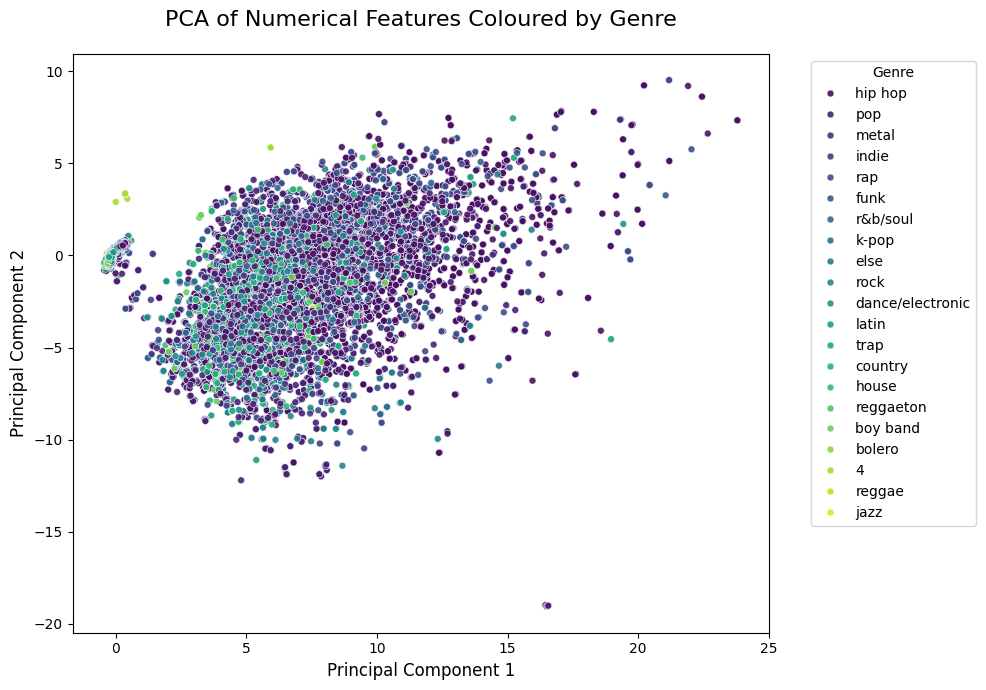

In [166]:
# Perform PCA analysis to visualize the high-dimensional data
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# Remove rows with nulls in numerical features (as required by VectorAssembler)
pca_ready_df = filtered_df.dropna(subset=numerical_features)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_assembled")
df_with_features = assembler.transform(pca_ready_df)

# Scale the features
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled")
scaler_model = scaler.fit(df_with_features)
df_scaled = scaler_model.transform(df_with_features)

# Apply PCA to the scaled features
pca = PCA(k=2, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
pca_result = pca_model.transform(df_scaled)

# Convert PCA result to Pandas for visualization
pandas_df = pca_result.select("pca_features", "Genre_new", 'positive', 'Explicit_true').toPandas()
pandas_df[['PCA1', 'PCA2']] = pandas_df['pca_features'].apply(lambda x: list(x)).to_list()

# Create a scatter plot for PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Genre_new",  # Color by Genre_new
    data=pandas_df,
    palette="viridis",
    s=25,  # Point size
    alpha=0.9  # Transparency
)

# Add labels and title
plt.title("PCA of Numerical Features Coloured by Genre", fontsize=16, pad=20)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Add legend and layout adjustments
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

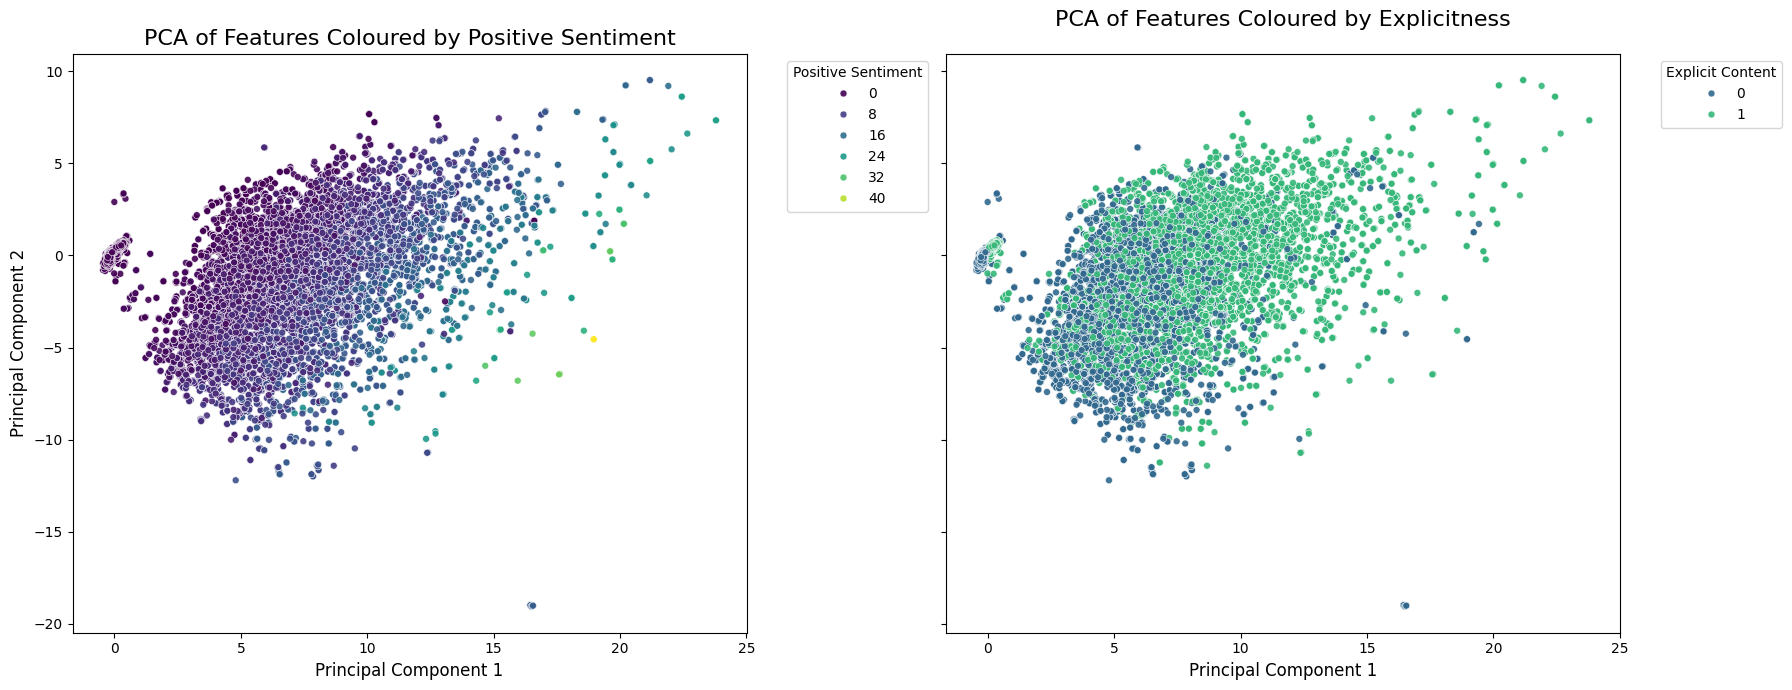

In [167]:
# Create 2 more subplots for PCA results with different hues
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# PCA with hue = 'positive'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="positive",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[0]
)
axes[0].set_title("PCA of Features Coloured by Positive Sentiment", fontsize=16)
axes[0].set_xlabel("Principal Component 1", fontsize=12)
axes[0].set_ylabel("Principal Component 2", fontsize=12)
axes[0].legend(title="Positive Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: PCA with hue = 'Explicit_true'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Explicit_true",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[1]
)
axes[1].set_title("PCA of Features Coloured by Explicitness", fontsize=16, pad=20)
axes[1].set_xlabel("Principal Component 1", fontsize=12)
axes[1].legend(title="Explicit Content", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

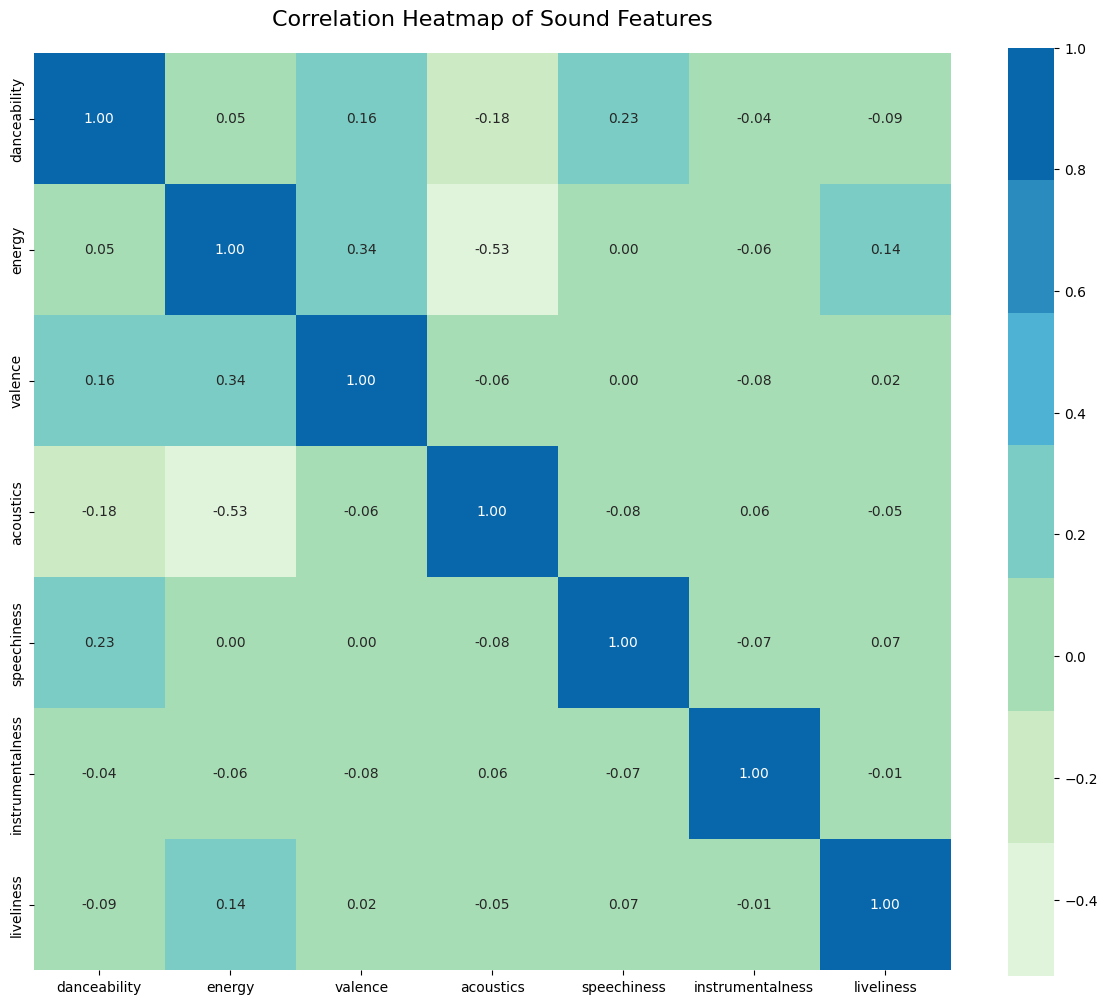

In [169]:
# Plot a heatmap showing correlation of sound features

# Select sound features to analyze
sound_features = ['danceability', 'energy', 'valence', 'acoustics', 'speechiness', 'instrumentalness', 'liveliness']

# Create a subset DataFrame
subset_df = filtered_df.select(*sound_features)

# Convert to Pandas DataFrame for correlation computation
pandas_df = subset_df.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df.corr(method='pearson')

# Generate colors
colors = sns.color_palette("GnBu", len(sound_features))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=colors, cbar=True, square=True)

# Customize the plot
plt.title("Correlation Heatmap of Sound Features", fontsize=16, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

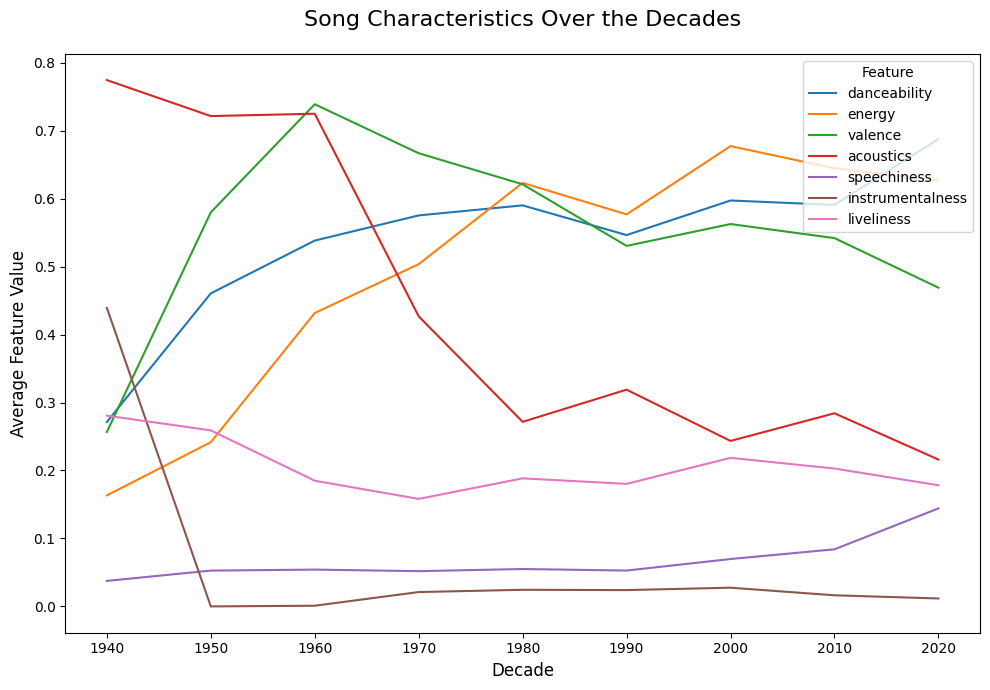

In [172]:
# Plot sound features over the decades
from pyspark.sql import functions as func

# Group by Decade and calculate the mean for each feature
aggregated_df = (filtered_df
                 .withColumn("Decade", func.round(func.year(func.to_date("Release_Date", "yyyy-MM-dd")), -1))
                 .groupBy("Decade")
                 .agg(
                     *[func.avg(feature).alias(feature) for feature in sound_features]
                 )
                 .orderBy("Decade")
                 .toPandas()
                 .dropna()  # Drop rows with missing values
                )

# Melt data for seaborn plotting
melted_df = aggregated_df.melt(id_vars="Decade",
                                value_vars=sound_features,
                                var_name="Feature",
                                value_name="Value")

# Plot using Seaborn
plt.figure(figsize=(10, 7))
sns.lineplot(data=melted_df, x="Decade", y="Value", hue="Feature")

# Customize plot
plt.title("Song Characteristics Over the Decades", fontsize=16, pad=20)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average Feature Value", fontsize=12)
plt.legend(title="Feature", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

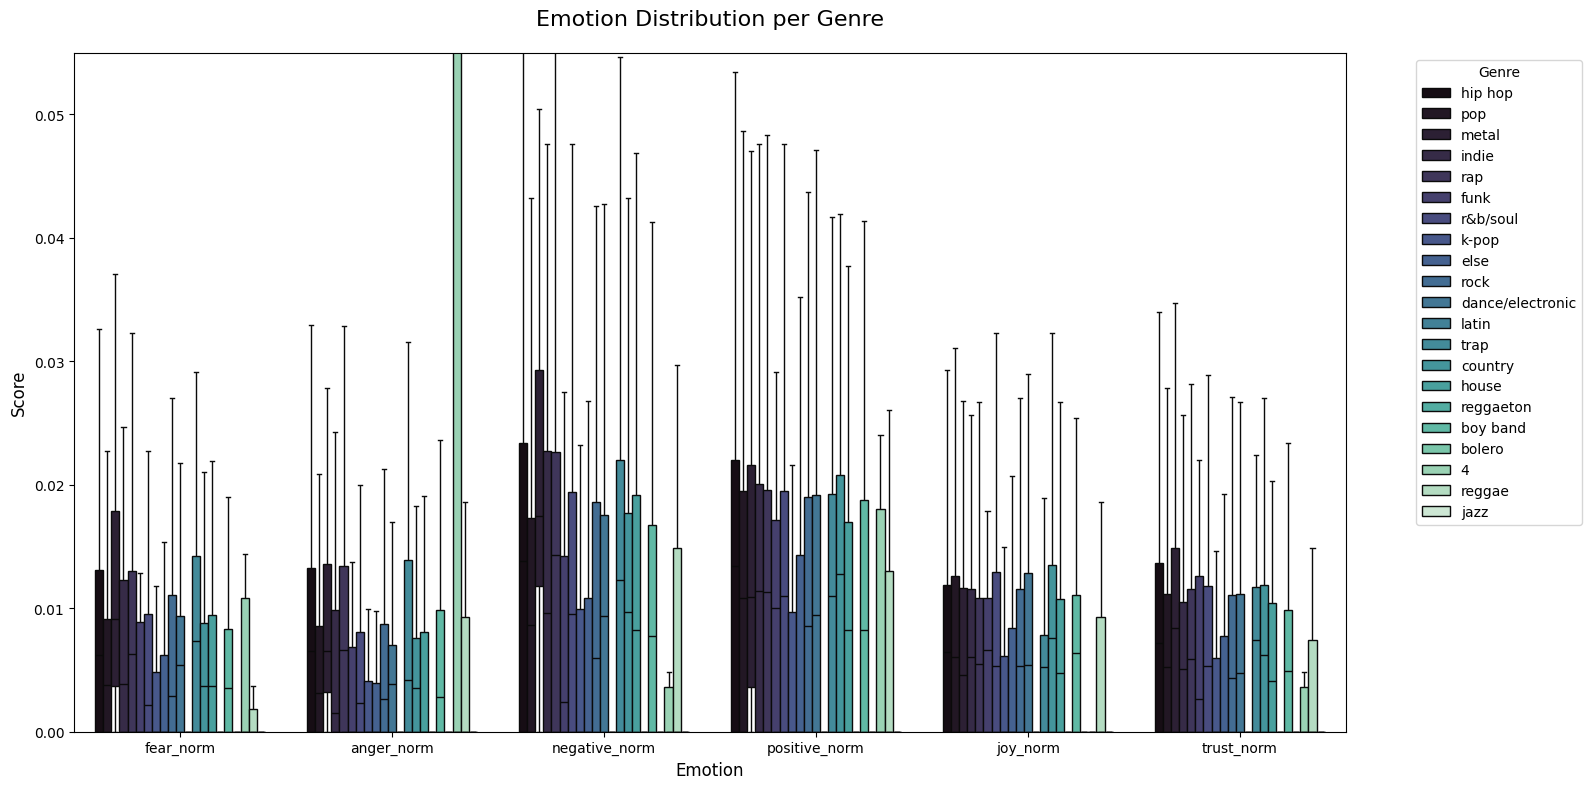

In [175]:
# Plot emotion distribtuion per Genre
sentiment_scores = ["fear_norm", "anger_norm", "negative_norm", "positive_norm", "joy_norm", "trust_norm"]

# Select relevant columns (sentiment scores + Genre)
emotion_df = filtered_df.dropna(subset=numerical_features).select(sentiment_scores + ["Genre_new"]).toPandas()

# Melt the data for easier plotting
melted_df = emotion_df.melt(
    id_vars="Genre_new",
    value_vars=sentiment_scores,
    var_name="Emotion",
    value_name="Score"
)

# Plot the data
plt.figure(figsize=(16, 8))
sns.boxplot(data=melted_df, x="Emotion", y="Score", hue="Genre_new", palette = 'mako', showfliers=False)

# Customize the plot
plt.title("Emotion Distribution per Genre", fontsize=16, pad=20)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 0.055)  # Adjust y-axis to match the range of norms
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()

# Show the plot
plt.show()

# Data Filtering

# Feature Seleciton

In [122]:
# Using filter methods to perform feature reduction
from pyspark.sql.functions import corr
from pyspark.sql.types import StringType
import math
correlations = []

for column in filtered_df.columns:
  if column != 'PopularityCategory' and column != 'Popularity' and not isinstance(filtered_df.schema[column].dataType, StringType):
    correlation = filtered_df.select(corr(column, 'Popularity')).collect()[0][0]
    if correlation != None and not math.isnan(correlation):
     correlations.append((column, abs(correlation)))

correlations.sort(key=lambda x: x[1], reverse=True)
# Take only the top 40 results
correlations = correlations[:40]
print(correlations)

[('Top50_dummy', 0.4346431592670897), ('Popu_max', 0.4340389702408112), ('latin', 0.15300185707867855), ('Mexico', 0.1527521861578449), ('Artist_followers', 0.11137668540120713), ('danceability', 0.09937458018679889), ('USA', 0.08694518459194184), ('loudness', 0.08289056786066452), ('hip hop', 0.081238495360119), ('Track_number', 0.07619440454606241), ('single', 0.07152882386888473), ('valence', 0.07038985083763921), ('Tracks_in_album', 0.06620718654602113), ('album31', 0.065794229677695), ('Explore', 0.05704048392975408), ('Top10_dummy', 0.055777983690837266), ('Released_after_2017', 0.04954463542320316), ('anger_norm', 0.04935757335234637), ('negative_norm', 0.04629730720985017), ('Explicit_true', 0.04590524850461089), ('Explicit_false', 0.044767982751107945), ('positive_norm', 0.04358691767821842), ('fear_norm', 0.04340278886681954), ('trust_norm', 0.04287677048413806), ('anticipation_norm', 0.042529791221222434), ('sadness_norm', 0.04240922408778379), ('k-pop', 0.04167491599878745)

In [146]:
# Convert popularity category we made prior to an indexed label
from pyspark.ml.feature import StringIndexer

wrapper_df = filtered_df.drop("Popularity")

indexer = StringIndexer(inputCol="PopularityCategory", outputCol="label")
wrapper_model_df = indexer.fit(wrapper_df).transform(wrapper_df)

In [148]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

wrapper_cols = [col for col, dtype in wrapper_model_df.dtypes if dtype != 'string' and col != 'label']

assembler = VectorAssembler(inputCols=wrapper_cols, outputCol="features", handleInvalid = "keep")
wrapper_model_df = assembler.transform(wrapper_model_df).select("features", "label")

In [150]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf_tester = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_wrapper_model = rf_tester.fit(wrapper_model_df)

importance = rf_wrapper_model.featureImportances
feature_importance = sorted(zip(importance, wrapper_cols), key=lambda x: x[0], reverse=True)
# take only the top 40 results
feature_importance = feature_importance[:40]
print(feature_importance)


[(0.35173979050264514, 'Popu_max'), (0.272109532419871, 'Top50_dummy'), (0.17257262020787278, 'Top10_dummy'), (0.03874501040968073, 'Tracks_in_album'), (0.029649630844568453, 'Mexico'), (0.014534806820969545, 'Days_since_release'), (0.01405039214770141, 'Artist_followers'), (0.011945257314226793, 'danceability'), (0.007604749766351819, 'Explicit_true'), (0.006416031253639616, 'loudness'), (0.006379492743263673, 'USA'), (0.005133054407179995, 'Track_number'), (0.0045611759036878335, 'latin'), (0.0037852734943987975, 'single'), (0.0036031013724190293, 'pop'), (0.003410198619703397, 'trust_norm'), (0.003085147774156374, 'hip hop'), (0.002980282498778801, 'afinn'), (0.002815577342588942, 'liveliness'), (0.00236436095340511, 'duration_ms'), (0.002245342811580101, 'speechiness'), (0.0019848297775791855, 'Explicit_false'), (0.0019709094992764803, 'valence'), (0.0019215863826490067, 'energy'), (0.0019060573550727915, 'instrumentalness'), (0.0018716446189343614, 'fear_norm'), (0.001743733970568

In [152]:
# Combining results - features that don't appear in either feature_importance or correlations will be removed

filter1 = [tup[0] for tup in correlations]

filter2 = [tup[1] for tup in feature_importance]

filtered_fnames = list(set(filter1) | set(filter2))
print("Number of features after reduction:", len(filtered_fnames))


Number of features after reduction: 54


# Model 1 (Popularity Predictor)

In [153]:
from ast import mod

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Re-assemble filtered features
feature_columns = [col for col, dtype in filtered_df.dtypes if dtype != 'string']

indexer = StringIndexer(inputCol="PopularityCategory", outputCol="label")
model1_df = indexer.fit(filtered_df).transform(filtered_df)

for fname in filtered_fnames:
  model1_df = model1_df.withColumn(fname, col(fname).cast("double"))

model1_df = model1_df.dropna()

assembler = VectorAssembler(inputCols=filtered_fnames, outputCol="features", handleInvalid = "keep")
model1_df = assembler.transform(model1_df).select("features", "label")

model1_df.select("features").show(truncate=False)

# Split data into train and test sets
train_df, test_df = model1_df.randomSplit([0.8, 0.2], seed=42)
#big, small = model1_df.randomSplit([0.9, 0.1], seed=42)
#train_df, test_df = small.randomSplit([0.8, 0.2], seed=42)

# Initialize the classifiers
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=42)
lr_classifier = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
+-----------------------------------------------------------------------------

In [154]:
# Create parameter grids for each classifier
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf_classifier.numTrees, [50, 100])
                .addGrid(rf_classifier.maxDepth, [5, 10])
                .build())

dt_paramGrid = (ParamGridBuilder()
                .addGrid(dt_classifier.maxDepth, [5, 10, 15])
                .addGrid(dt_classifier.minInstancesPerNode, [1, 2, 4])
                .build())

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr_classifier.regParam, [0.01, 0.1, 1.0])
                .addGrid(lr_classifier.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

In [155]:
# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up CrossValidators for each model
rf_cv = CrossValidator(estimator=rf_classifier,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

dt_cv = CrossValidator(estimator=dt_classifier,
                       estimatorParamMaps=dt_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

lr_cv = CrossValidator(estimator=lr_classifier,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=evaluator,
                       numFolds=3,
                       parallelism=2)

In [156]:
# Fit the models
print("Fitting Random Forest model...")
rf_model = rf_cv.fit(train_df)
print("Fitting Decision Tree model...")
dt_model = dt_cv.fit(train_df)
print("Fitting Logistic Regression model...")
lr_model = lr_cv.fit(train_df)

Fitting Random Forest model...
Fitting Decision Tree model...
Fitting Logistic Regression model...


In [157]:
# Make predictions on the test set
rf_predictions = rf_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)
lr_predictions = lr_model.transform(test_df)

# Evaluate the models
rf_accuracy = evaluator.evaluate(rf_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")

Random Forest Accuracy: 0.8665919282511211
Decision Tree Accuracy: 0.8340807174887892
Logistic Regression Accuracy: 0.827354260089686


In [158]:
# Determine the best model
accuracies = {'Random Forest': rf_accuracy, 'Decision Tree': dt_accuracy, 'Logistic Regression': lr_accuracy}
best_model_name = max(accuracies, key=accuracies.get)
print(f"The best model is: {best_model_name} with an accuracy of {accuracies[best_model_name]}")

# Access the best model and its parameters
if best_model_name == 'Random Forest':
    best_model = rf_model.bestModel
    best_params = rf_model.bestModel.extractParamMap()
elif best_model_name == 'Decision Tree':
    best_model = dt_model.bestModel
    best_params = dt_model.bestModel.extractParamMap()
else:
    best_model = lr_model.bestModel
    best_params = lr_model.bestModel.extractParamMap()

print("Best Model Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

The best model is: Random Forest with an accuracy of 0.8665919282511211
Best Model Parameters:
RandomForestClassifier_3f2acb1dc910__bootstrap: True
RandomForestClassifier_3f2acb1dc910__cacheNodeIds: False
RandomForestClassifier_3f2acb1dc910__checkpointInterval: 10
RandomForestClassifier_3f2acb1dc910__featureSubsetStrategy: auto
RandomForestClassifier_3f2acb1dc910__featuresCol: features
RandomForestClassifier_3f2acb1dc910__impurity: gini
RandomForestClassifier_3f2acb1dc910__labelCol: label
RandomForestClassifier_3f2acb1dc910__leafCol: 
RandomForestClassifier_3f2acb1dc910__maxBins: 32
RandomForestClassifier_3f2acb1dc910__maxDepth: 10
RandomForestClassifier_3f2acb1dc910__maxMemoryInMB: 256
RandomForestClassifier_3f2acb1dc910__minInfoGain: 0.0
RandomForestClassifier_3f2acb1dc910__minInstancesPerNode: 1
RandomForestClassifier_3f2acb1dc910__minWeightFractionPerNode: 0.0
RandomForestClassifier_3f2acb1dc910__numTrees: 100
RandomForestClassifier_3f2acb1dc910__predictionCol: prediction
RandomFor

# Model 2 (KNN Music Recommender)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.sql import DataFrame

# Step 1: Aggregate features by Uri, retaining Title and Artist
model2_df = transformed_df.groupBy("Uri").agg(
    F.first("Title").alias("Title"),
    F.first("Artist").alias("Artist"),
    F.avg("danceability").alias("danceability"),
    F.avg("energy").alias("energy"),
    F.avg("loudness").alias("loudness"),
    F.avg("acoustics").alias("acoustics"),
    F.avg("instrumentalness").alias("instrumentalness"),
    F.avg("liveliness").alias("liveliness"),
    F.avg("valence").alias("valence"),
    F.avg("tempo").alias("tempo")
)

audio_features = ['danceability', 'energy', 'loudness', 'acoustics',
                  'instrumentalness', 'liveliness', 'valence', 'tempo']
model2_df = model2_df.fillna(0, subset=audio_features)
# Combine audio features into a single vector column
assembler = VectorAssembler(inputCols=audio_features, outputCol="features")
data_with_features = assembler.transform(model2_df)  # Replace 'data' with your PySpark DataFrame



In [ ]:
# Step 2: Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_with_features)
data_scaled = scaler_model.transform(data_with_features)

In [ ]:
# Step 3: Define the recommendation function including Title and Artist in the output
def get_recommendations(df: DataFrame, target_uri: str, n_recommendations: int = 5) -> DataFrame:
    """
    Get song recommendations based on Euclidean distance to a target song by Uri.

    Parameters:
    df (DataFrame): The PySpark DataFrame containing scaled features.
    target_uri (str): The Uri of the target song.
    n_recommendations (int): Number of recommendations to retrieve.

    Returns:
    DataFrame: A PySpark DataFrame of recommended songs including Uri, Title, and Artist.
    """
    # Extract the feature vector of the target song by Uri
    target_song = df.where(F.col("Uri") == target_uri).select("scaled_features").first()

    # Check if target_song exists
    if not target_song:
        raise ValueError(f"Uri {target_uri} not found in the dataset.")

    target_vector = target_song["scaled_features"]

    # Define a UDF to calculate Euclidean distance
    def euclidean_distance(v1, v2):
        return float(v1.squared_distance(v2)) ** 0.5

    distance_udf = F.udf(lambda v: euclidean_distance(target_vector, v), FloatType())

    # Calculate distances and get the closest songs
    df_with_distances = df.withColumn("distance", distance_udf(F.col("scaled_features")))
    recommendations = (df_with_distances
                       .filter(F.col("Uri") != target_uri)  # Exclude the target song itself
                       .select("Uri", "Title", "Artist", "distance")  # Include Uri, Title, Artist
                       .orderBy("distance")
                       .limit(n_recommendations))

    return recommendations

In [ ]:
# Example usage:
recommendations_df = get_recommendations(data_scaled, target_uri="https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk", n_recommendations=5)
recommendations_df.show()

+--------------------+------------------+--------------------+----------+
|                 Uri|             Title|              Artist|  distance|
+--------------------+------------------+--------------------+----------+
|https://open.spot...|        adan y eva|        Paulo Londra|0.04859169|
|https://open.spot...|la jeepeta - remix|Nio Garcia - Anue...|0.43462214|
|https://open.spot...|la jeepeta - remix|Nio Garcia - Anue...|0.44388047|
|https://open.spot...|       fuego lento|          Drake Bell| 0.5159253|
|https://open.spot...|     supuestamente|    Ozuna - Anuel AA|0.57871056|
+--------------------+------------------+--------------------+----------+

